In [4]:
from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *

In [3]:
import numpy as np
from fastcore.xtras import Path # @patch'd properties to the Pathlib module

from fastai.callback.fp16 import to_fp16
from fastai.callback.schedule import fit_one_cycle, lr_find 

from fastai.data.block import CategoryBlock, DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, Normalize, RandomSplitter, RegexLabeller

from fastai.interpret import ClassificationInterpretation
from fastai.learner import Learner # imports @patch'd properties to Learner including `save`, `load`, `freeze`, and `unfreeze`

from fastai.metrics import error_rate

from fastai.vision.augment import aug_transforms, RandomResizedCrop
from fastai.vision.core import imagenet_stats
from fastai.vision.data import ImageDataLoaders, ImageBlock
from fastai.vision.learner import cnn_learner

from torchvision.models.resnet import resnet34, resnet50

In [3]:
path = Path('/home/helen/dataset/oxford-iiit-pet/')

In [4]:
np.random.seed(2)
fnames = get_image_files(path/'images')
pat = r'(.+)_\d+.jpg$'

item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
bs=64

In [5]:
dls = ImageDataLoaders.from_name_re(path, fnames, pat, batch_tfms=batch_tfms, 
                                   item_tfms=item_tfms, bs=bs)

In [15]:
# del learn
learn = cnn_learner(dls, resnet34, pretrained=True, metrics=error_rate).to_fp16()

In [16]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [17]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,3.157439,0.812904,0.230717,00:23
1,1.032994,0.298834,0.098782,00:23
2,0.494226,0.250405,0.093369,00:23
3,0.331112,0.233471,0.075778,00:23
4,0.243720,0.213074,0.076455,00:23
5,0.203158,0.204519,0.071042,00:23
6,0.161712,0.208159,0.072395,00:23
7,0.156835,0.194600,0.072395,00:23
8,0.123576,0.193831,0.070365,00:23
9,0.118077,0.192575,0.068336,00:23


In [18]:
del learn
import gc; gc.collect()
torch.cuda.empty_cache()

In [34]:
labels = torch.tensor([[1],[2]])
print(torch.eye(3))
print(torch.eye(3)[labels])

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])
tensor([[[0., 1., 0.]],

        [[0., 0., 1.]]])


In [8]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels].cuda()

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ.squeeze(), self.num_classes)
        w = self.get_weight(pred,t)
        return F.binary_cross_entropy_with_logits(pred, t, None if w is None else w.detach(), reduction='sum')/self.num_classes
    
    def get_weight(self,x,t): return None
class FocalLoss(BCE_Loss):
    def get_weight(self,x,t):
        alpha,gamma = 0.25,1
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)

In [20]:
learn = cnn_learner(dls, resnet34, pretrained=True, loss_func=BCE_Loss(len(dls.vocab)), metrics=error_rate).to_fp16()
learn.loss_func

BCE_Loss()

SuggestedLRs(valley=0.004365158267319202)

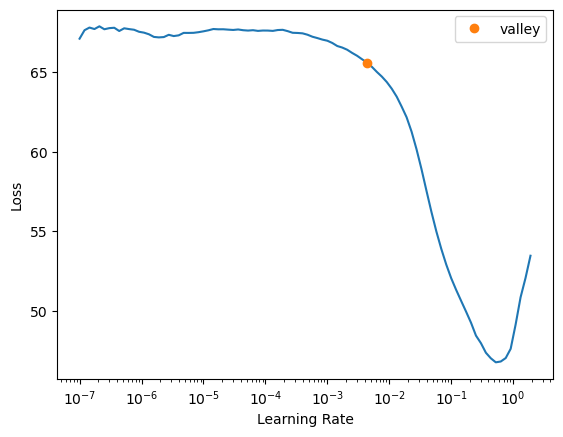

In [9]:
learn.lr_find()

In [21]:
learn.fit_one_cycle(10, 0.0043)

epoch,train_loss,valid_loss,error_rate,time
0,55.308769,33.750668,0.225304,00:23
1,15.038496,1.811663,0.108254,00:23
2,3.940043,1.122518,0.096076,00:23
3,1.784784,1.038310,0.089310,00:23
4,1.245446,1.058764,0.102842,00:23
5,0.978293,0.861395,0.079838,00:23
6,0.844520,0.799335,0.079838,00:23
7,0.692126,0.768706,0.074425,00:23
8,0.535630,0.720397,0.070365,00:23
9,0.478655,0.713542,0.069012,00:23


In [22]:
del learn
learn = cnn_learner(dls, resnet34, pretrained=True, loss_func=FocalLoss(len(dls.vocab)), metrics=error_rate).to_fp16()

SuggestedLRs(valley=0.0063095735386013985)

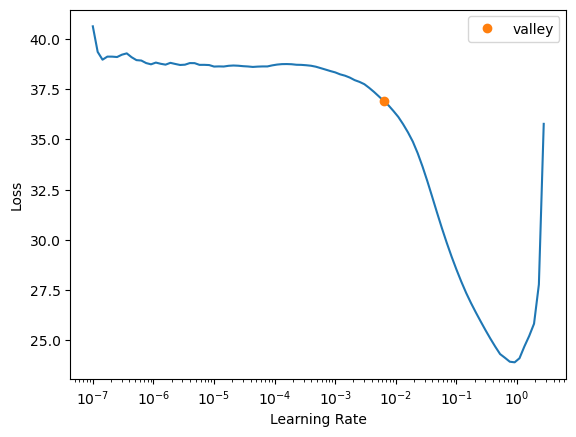

In [12]:
learn.lr_find()

In [23]:
learn.fit_one_cycle(10, 0.0063)

epoch,train_loss,valid_loss,error_rate,time
0,26.141027,8.162519,0.321380,00:22
1,5.110258,0.353058,0.121786,00:22
2,1.204886,0.247220,0.092693,00:23
3,0.489554,0.222047,0.087957,00:23
4,0.317949,0.201170,0.094046,00:22
5,0.260867,0.193504,0.079838,00:23
6,0.220323,0.173054,0.072395,00:23
7,0.173299,0.150697,0.070365,00:23
8,0.147493,0.150370,0.071719,00:23
9,0.133588,0.148003,0.069689,00:22


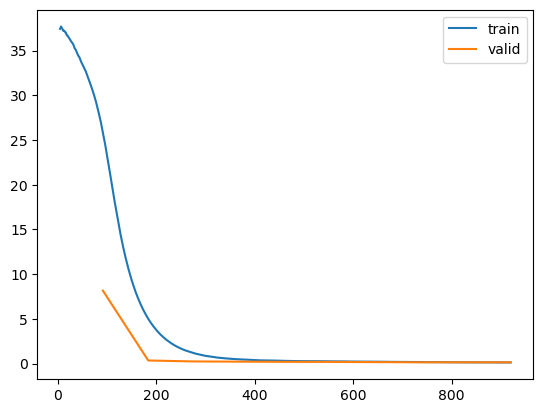

In [28]:
learn.recorder.plot_loss()

In [30]:
??learn.recorder.plot_loss

Signature: learn.recorder.plot_loss(skip_start=5, with_valid=True)
Docstring: Plot the losses from `skip_start` and onward
Source:   
    def plot_loss(self, skip_start=5, with_valid=True):
        plt.plot(list(range(skip_start, len(self.losses))), self.losses[skip_start:], label='train')
        if with_valid:
            idx = (np.array(self.iters)<skip_start).sum()
            valid_col = self.metric_names.index('valid_loss') - 1 
            plt.plot(self.iters[idx:], L(self.values[idx:]).itemgot(valid_col), label='valid')
            plt.legend()
File:      ~/fastai2/fastai/fastai/learner.py
Type:      method


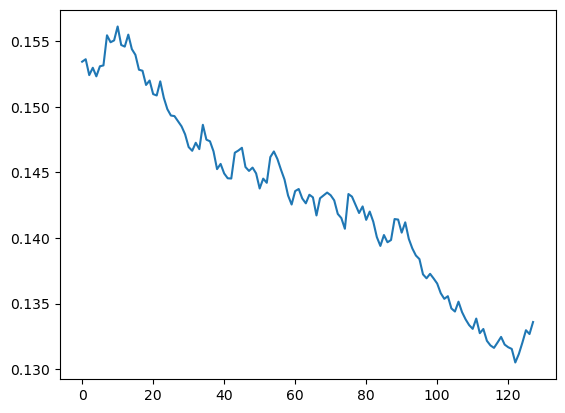

In [35]:
plt.plot(learn.recorder.losses[-128:])

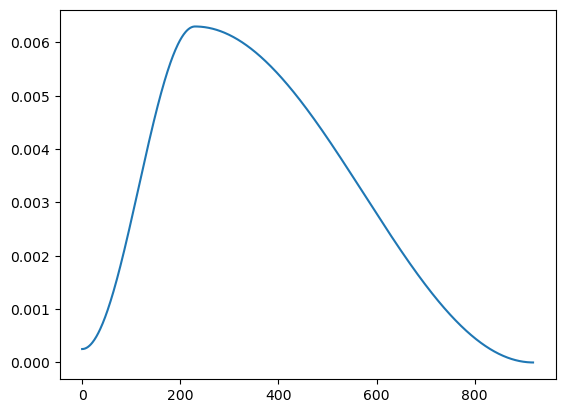

In [39]:
plt.plot(learn.recorder.lrs)

In [28]:
print(len(learn.model))
# print(learn.model[0])
print(learn.model[1])

2
Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=37, bias=False)
)


In [29]:
64*37

2368

In [30]:
batch = dls.one_batch()

In [32]:
print(len(batch))
batch[1][0]

2


TensorCategory(27, device='cuda:0')

# 手动制作不平衡的数据集，看效果
- /home/helen/dataset/oxford-iiit-pet-non-balance 中删除100张第一个类别，这样就有了一个不平衡的类别了，看下效果是否如预期

In [40]:
dls

In [5]:
path = Path('/home/helen/dataset/oxford-iiit-pet-non-balance/')
np.random.seed(2)
fnames = get_image_files(path/'images')
pat = r'(.+)_\d+.jpg$'

item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
bs=64

dls = ImageDataLoaders.from_name_re(path, fnames, pat, batch_tfms=batch_tfms, 
                                   item_tfms=item_tfms, bs=bs)

In [48]:
print(len(fnames))
print(len(dls.train), len(dls.valid), len(dls.train_ds), len(dls.valid_ds))
print(len(fnames) / len(dls.vocab))

7300
91 23 5840 1460
197.2972972972973


SuggestedLRs(valley=0.0004786300996784121)

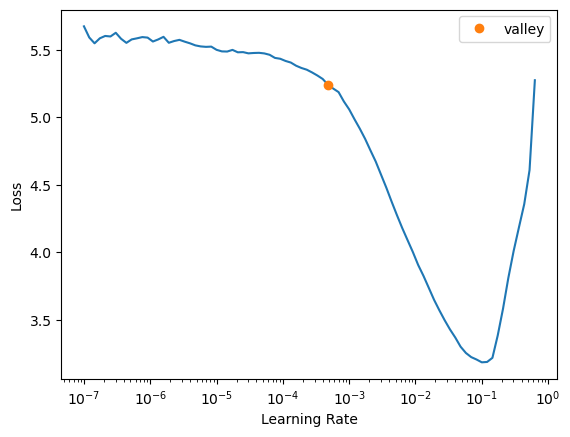

In [42]:
learn = cnn_learner(dls, resnet34, pretrained=True, metrics=error_rate).to_fp16()
print(learn.loss_func)
learn.lr_find()

In [43]:
learn.fit_one_cycle(10,0.0004786)

epoch,train_loss,valid_loss,error_rate,time
0,4.115259,1.800960,0.450000,00:24
1,1.604360,0.417223,0.130822,00:23
2,0.713614,0.290573,0.091096,00:23
3,0.458850,0.244203,0.078767,00:23
4,0.353849,0.229378,0.076027,00:23
5,0.276094,0.213135,0.072603,00:23
6,0.236408,0.215661,0.075342,00:23
7,0.209755,0.209858,0.067123,00:23
8,0.199741,0.210084,0.065068,00:23
9,0.176960,0.211835,0.065753,00:23


SuggestedLRs(valley=0.00363078061491251)

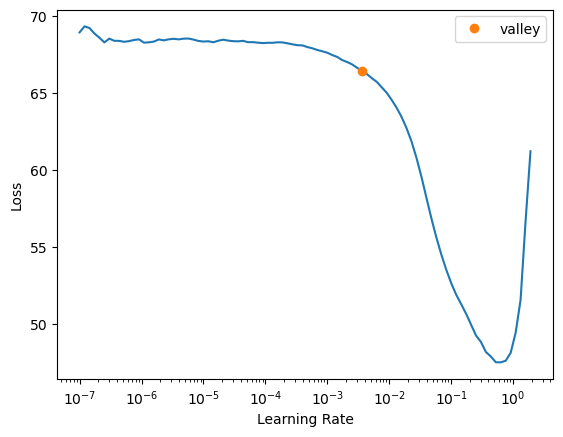

In [9]:
# del learn
learn = cnn_learner(dls, resnet34, pretrained=True, loss_func=BCE_Loss(len(dls.vocab)), metrics=error_rate).to_fp16()
learn.lr_find()

In [10]:
print(learn.loss_func)
learn.fit_one_cycle(10, 0.0036)

epoch,train_loss,valid_loss,error_rate,time
0,57.401691,37.588783,0.237671,00:23
1,18.004339,2.075202,0.123288,00:23
2,4.640575,1.101632,0.080137,00:23
3,1.978584,0.897017,0.080137,00:24
4,1.314741,0.825024,0.075342,00:23
5,1.058455,0.788323,0.073288,00:23
6,0.874422,0.687669,0.063014,00:23
7,0.707588,0.647943,0.059589,00:23
8,0.603122,0.619399,0.055479,00:23
9,0.561958,0.619715,0.058219,00:23


SuggestedLRs(valley=0.004365158267319202)

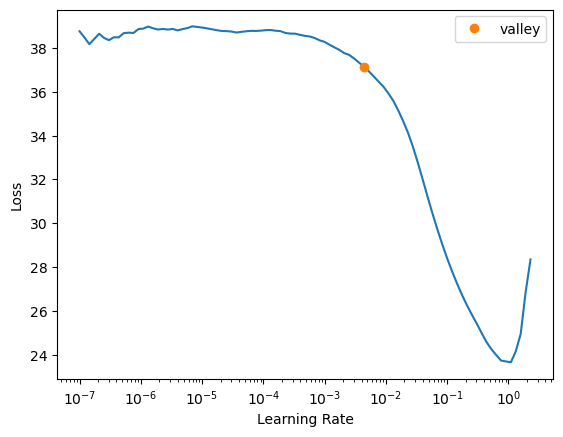

In [11]:
del learn
learn = cnn_learner(dls, resnet34, pretrained=True, loss_func=FocalLoss(len(dls.vocab)), metrics=error_rate).to_fp16()
learn.lr_find()

In [12]:
print(learn.loss_func)
learn.fit_one_cycle(10, 0.0043)

epoch,train_loss,valid_loss,error_rate,time
0,29.410666,13.242126,0.378767,00:23
1,7.433159,0.425592,0.136301,00:23
2,1.677908,0.258874,0.095890,00:23
3,0.624792,0.212179,0.086986,00:23
4,0.377419,0.182402,0.078767,00:23
5,0.287668,0.172771,0.084932,00:23
6,0.238415,0.158802,0.069863,00:23
7,0.197278,0.145718,0.067123,00:24
8,0.178721,0.143312,0.065753,00:23
9,0.164849,0.140727,0.065068,00:23
